In [1]:
import numpy as np                        # Math
import scipy.stats                        # Statistics
from matplotlib import pyplot as plt      # Plots

In [2]:
input_file_path = '/Users/giulia/coding/astrostat/astrostatistics_bicocca_2024/solutions/galaxyquasar.csv'
input_file = open(input_file_path)
#data = input_file.read()
#input_file.close()

In [3]:
import pandas as pd

data = pd.read_csv(input_file_path)
data

,u,g,r,i,z,class,z1,zerr
0,18.97213,18.53676,18.58280,18.34936,18.29215,QSO,0.522819,0.000155
1,19.24592,17.47646,16.47817,16.04472,15.68851,GALAXY,0.122846,0.000028
2,19.43536,17.70268,16.91565,16.58327,16.39128,GALAXY,0.000000,0.000000
3,19.31626,18.18312,17.39591,16.94549,16.65395,GALAXY,0.147435,0.000009
4,19.28828,19.11188,18.88937,18.80013,18.49183,QSO,2.011455,0.000631
...,...,...,...,...,...,...,...,...
49995,19.37295,18.12382,17.39886,16.98503,16.70585,GALAXY,0.113016,0.000011
49996,18.52021,16.88262,16.03280,15.56884,15.22454,GALAXY,0.085063,0.000014
49997,18.62718,17.30876,16.87371,16.62399,16.42296,GALAXY,0.054429,0.000008
49998,19.55140,18.27711,17.62101,17.21947,17.03347,GALAXY,0.112571,0.000009


Color array

In [4]:
u_g = data['u'] - data['g']
g_r = data['g'] - data['r']
r_i = data['r'] - data['i']
i_z = data['i'] - data['z']

In [5]:
X = np.array([u_g,g_r,r_i,i_z]).T
print(X)

[[ 0.43537 -0.04604  0.23344  0.05721]
 [ 1.76946  0.99829  0.43345  0.35621]
 [ 1.73268  0.78703  0.33238  0.19199]
 ...
 [ 1.31842  0.43505  0.24972  0.20103]
 [ 1.27429  0.6561   0.40154  0.186  ]
 [ 1.05021  0.35251  0.1885   0.09355]]


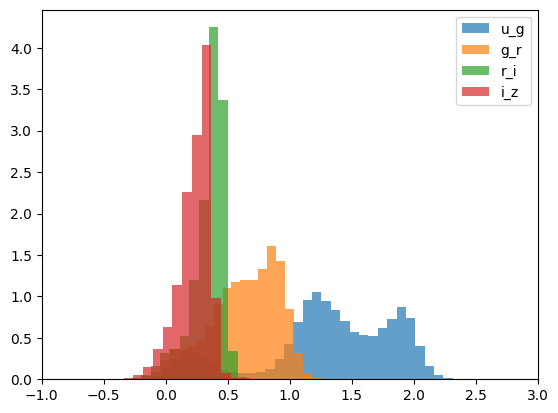

In [6]:
plt.hist(u_g, 100, density=True, label='u_g', alpha=0.7)
plt.hist(g_r, 200, density=True, label='g_r', alpha=0.7)
plt.hist(r_i, 300, density=True, label='r_i', alpha=0.7)
plt.hist(i_z, 300, density=True, label='i_z', alpha=0.7)
plt.xlim(-1, +3)
plt.legend()
plt.show()

Label array:

galaxy --> 0

quasar --> 1

In [7]:
# Define the mapping
name_to_number = {"GALAXY": 0, "QSO": 1}

# Convert the string array to an array of 0s and 1s
labels = [name_to_number[name] for name in data['class']]
y=labels

In [8]:
from astroML.classification import GMMBayes
from astroML.utils.decorators import pickle_results
from astroML.utils import split_samples
from astroML.utils import completeness_contamination

In [9]:
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25],
                                                     random_state=0)

In [10]:
N_tot = len(y)
N_st = np.sum(y == 0)
N_rr = N_tot - N_st
N_train = len(y_train)
N_test = len(y_test)
N_plot = 5000 + N_rr

In [11]:
Ncolors = np.arange(1, X.shape[1] + 1)
Ncomp = [1, 5]

In [13]:
def compute_GMMbayes(Ncolors, Ncomp):
    classifiers = []
    predictions = []

    for ncm in Ncomp:
        classifiers.append([])
        predictions.append([])
        for nc in Ncolors:
            clf = GMMBayes(ncm, tol=1E-5, covariance_type='full')
            clf.fit(X_train[:, :nc], y_train)
            y_pred = clf.predict(X_test[:, :nc])

            classifiers[-1].append(clf)
            predictions[-1].append(y_pred)

    return classifiers, predictions

classifiers, predictions = compute_GMMbayes(Ncolors, Ncomp)

completeness, contamination = completeness_contamination(predictions, y_test)

print("completeness", completeness)
print("contamination", contamination)

completeness [[0.92743764 0.93027211 0.92687075 0.92573696]
 [0.93424036 0.92006803 0.93197279 0.92800454]]
contamination [[0.06300115 0.0665529  0.0651801  0.06632361]
 [0.06575964 0.05309218 0.0546291  0.05594002]]


In [18]:
print(predictions)

[[array([0, 0, 0, ..., 1, 0, 0]), array([0, 0, 0, ..., 1, 0, 0]), array([0, 0, 0, ..., 1, 0, 0]), array([0, 0, 0, ..., 1, 0, 0])], [array([0, 0, 0, ..., 1, 0, 0]), array([0, 0, 0, ..., 1, 0, 0]), array([0, 0, 0, ..., 1, 0, 0]), array([0, 0, 0, ..., 1, 0, 0])]]


In [19]:
# Compute the decision boundary
clf = classifiers[1][1]
xlim = (-10, 5)
ylim = (-2, 5)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 71),
                     np.linspace(ylim[0], ylim[1], 81))

Z = clf.predict_proba(np.c_[yy.ravel(), xx.ravel()])
Z = Z[:, 1].reshape(xx.shape)